In [1]:
# !rm -rf /kaggle/working/handwriting-generator-model
# !git clone https://github.com/Shambu-K/handwriting-generator-model.git
# !pip install fastdtw
# %cd /kaggle/working/handwriting-generator-model/Code/STR_model

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader
from model import STR_Model, STR_Model_Longer_512, STR_Model_Longer_1024
from dataset.iam_dataloader import HandwritingDataset
from loss.stroke_loss import STR_Loss
from util.visualize_progress import visualize_progress, plot_losses
from fastdtw import fastdtw
from tqdm.notebook import tqdm
import os

In [3]:
def train(model, train_loader, loss_function, optimizer, device, epoch=0):
    # Setting the model to training mode
    model.train() 
    length = len(train_loader)
    # Looping over each batch from the training set 
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), desc=f'Epoch {epoch}', total=length):  
        # data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  
        output = model(data)  
        loss = loss_function(output, target) 
        loss.backward()
        # Updating the model parameters
        optimizer.step() 

        if batch_idx % 100 == 0:
            print(f'   Batch: {batch_idx:<4} | Loss: {loss.item()}')
            
    return loss.item()

def model_fit(model, train_loader, loss_function, optimizer, scheduler, num_epochs, device, checkpoint, data_path, plot=True):
    train_losses = []
    for epoch in range(num_epochs):
        if plot: visualize_progress(model, device, data_path)
        print('=====================================================================\n')
        loss = train(model, train_loader, loss_function, optimizer, device, epoch+1)
        train_losses.append(loss)
        scheduler.step()
        if epoch % checkpoint == 0:
            model_file = f'./checkpoints/{model.__class__}_{epoch}_{int(loss)}.pth'
            torch.save(model.state_dict(), model_file) 
    
    return train_losses

# Util functions
def set_best_model(model, checkpoint_dir):
    ''' Set the model with least loss as the best model. '''
    best_loss = 100000
    best_model = None
    for file in os.listdir(checkpoint_dir):
        if file.endswith('.pth') and file.startswith(model.__class__.__name__):
            loss = int(file.split('_')[-1].split('.')[0])
            if loss < best_loss:
                best_loss = loss
                best_model = file
    if best_model is not None:
        model.load_state_dict(torch.load(os.path.join(checkpoint_dir, best_model)))
        print(f'Best model: {best_model}')

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# Training parameters
num_epochs = 100
batch_size = 16 # Archibald it is 32
checkpoint_interval = 1
learning_rate = 0.0001
lr_decay = 0.99

print('Using device:', device)

Using device: cuda


In [5]:
# Load data
# root_dir = '/kaggle/input/iam-dataset-online/Resized_Dataset/Train'
root_dir = '../../DataSet/IAM-Online/Resized_Dataset/Train/'
dataset = HandwritingDataset(root_dir, batch_size, device)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

Preprocessing data: 100%|██████████| 2740/2740 [00:28<00:00, 95.66it/s] 


In [6]:
# Model
model = STR_Model_Longer_1024().to(device)
set_best_model(model, './checkpoints/')
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay)
loss_function = STR_Loss(sos_weight=20)

Image id: 27371


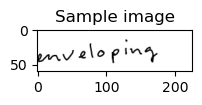

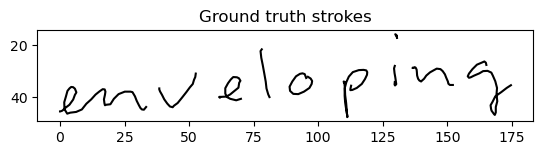

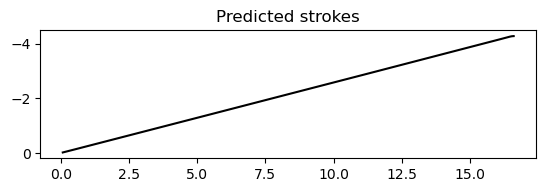

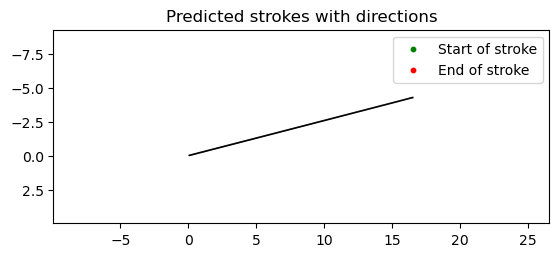

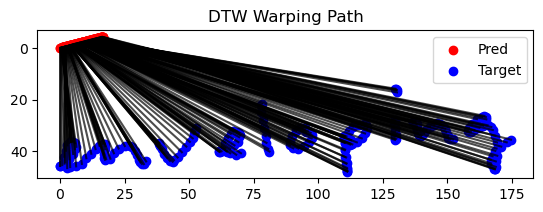

Epoch 1:   0%|          | 0/2740 [00:00<?, ?it/s]

   Batch: 0 | Loss: 528.6831706936607
   Batch: 100 | Loss: 348.78936492479744
   Batch: 200 | Loss: 346.49415886207817
   Batch: 300 | Loss: 330.4539205534174
   Batch: 400 | Loss: 298.4165098083896
   Batch: 500 | Loss: 289.0019003277119
   Batch: 600 | Loss: 285.65607004036195
   Batch: 700 | Loss: 362.94022480301874
   Batch: 800 | Loss: 321.82735088138344
   Batch: 900 | Loss: 422.29884156976334
   Batch: 1000 | Loss: 364.4161778990624
   Batch: 1100 | Loss: 379.48618619351134
   Batch: 1200 | Loss: 410.328860972957
   Batch: 1300 | Loss: 443.10908114327407
   Batch: 1400 | Loss: 414.6894978565242
   Batch: 1500 | Loss: 399.79890018015556
   Batch: 1600 | Loss: 453.8946540590639
   Batch: 1700 | Loss: 447.2201767609275
   Batch: 1800 | Loss: 447.64836904921066
   Batch: 1900 | Loss: 503.5543450146346
   Batch: 2000 | Loss: 544.4743509048922
   Batch: 2100 | Loss: 649.1010331252758
   Batch: 2200 | Loss: 552.1360454196806
   Batch: 2300 | Loss: 675.1371725517668
   Batch: 2400 | Lo

In [7]:
# Fitting the model
losses = model_fit(model, dataloader, loss_function, optimizer, scheduler, num_epochs, device, checkpoint_interval, root_dir, plot=True)